In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
import torch
import os
from datasets import DatasetDict, Dataset
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Use GPU 0 only

In [2]:


# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto", cache_dir= "/home/cr8dl-user/shibu/.cache"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
from datasets import load_dataset

ds = load_dataset("derek-thomas/ScienceQA")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
})


In [ ]:
for sample in ds["test"]:
    print(type(sample["image"])) # Assuming these are local file paths



<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<clas

In [8]:
from io import BytesIO
# Function to handle PIL image conversion
def pil_image_to_bytes(image: Image.Image) -> BytesIO:
    image_file = BytesIO()
    image.save(image_file, format="PNG")
    image_file.seek(0)
    return image_file

In [26]:
import random


def flip_image(image):
    """
    Flips the given PIL.Image either horizontally or vertically.

    Args:
        image (PIL.Image): The input image to flip.

    Returns:
        PIL.Image: The flipped image.
    """
    
    #return image.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)
    flipped_image.show()
  
    return image.transpose(Image.FLIP_TOP_BOTTOM)

In [11]:
import random

# Function to shuffle the words in a sentence
def shuffle_words(sentence):
    words = sentence.split()  # Split the sentence into words
    random.shuffle(words)  # Shuffle the list of words
    return ' '.join(words)  # Join the words back into a sentence

In [7]:
import random

# Function to rotate an image by a random angle
def rotate_image(image):
    """
    Rotates the given PIL.Image by a random angle.

    Args:
        image (PIL.Image): The input image to rotate.

    Returns:
        PIL.Image: The rotated image.
    """
    angle = random.randint(0, 360)  # Generate a random angle between 0 and 360 degrees
    print(f"Rotating image by {angle} degrees")  # Optional: Print the rotation angle for debugging
    rotated_image = image.rotate(angle, expand=True)
    rotated_image.show()
    return image.rotate(angle, expand=True)

In [18]:
def truncate_question(question,  keep_ratio=0.6):

    words = question.split()  # Split the question into words
    num_words_to_keep = max(1, int(len(words) * keep_ratio))  # Calculate number of words to keep
    return ' '.join(words[:num_words_to_keep])  # Keep only the first 'num_words_to_keep' words

Skipping sample 1: No image provided


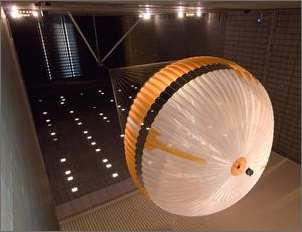

Processed sample 2/200
Accuracy: 0.00%


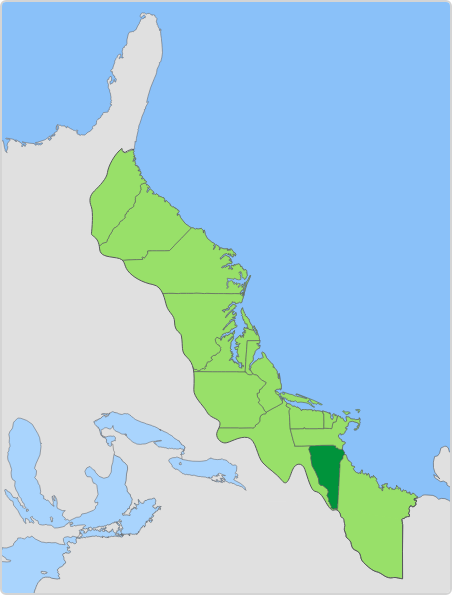

Processed sample 3/200
Accuracy: 0.00%


In [ ]:
results = []
correct_predictions = 0

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(3))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    # Skip processing if the sample does not have an image
    if image is None:  # Check if the image is not provided
        print(f"Skipping sample {idx + 1}: No image provided")
        continue

    try:
        flipped_image = flip_image(image)
        # truncated_question = truncate_question(question)
        shuffled_question = shuffle_words(question)
        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": flipped_image},
                {"type": "text", "text": f" Question: {question} \n Options: {options}.  Output the index of the correct answer. If the correct answer is the first one, output 0. If the correct answer is the second one, output 1, and so on."},
            ]}
        ]

        # Process visual inputs
        image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]
            
        # Convert the model's output text to an integer index
        predicted_index = int(output_text.strip())

        # Check if the prediction is correct
        correct_index = sample["answer"]
        if predicted_index == correct_index:
            correct_predictions += 1  # Increment correct predictions count


        # Append the result
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_index": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/200")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_index": "Error during processing",
            "correct_index": sample.get("answer", None)
        })
        
        # Calculate accuracy
    accuracy = (correct_predictions / len(results)) * 100 if results else 0
    print(f"Accuracy: {accuracy:.2f}%")



In [29]:
for result in results:
    print(f"Index: {results.index(result) + 1}")
    print("Question:", result["question"])
    print("Actual Choices:", result["actual_choices"])
    print("Predicted Answer Index:", result["predicted_index"])
    print("Correct Answer Index:", result["correct_index"])
    print("-" * 50)
    

Index: 1
Question: Which of the following could Gordon's test show?
Actual Choices: ['if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour', 'how steady a parachute with a 1 m vent was at 200 km per hour', 'whether a parachute with a 1 m vent would swing too much at 400 km per hour']
Predicted Answer Index: Error during processing
Correct Answer Index: 1
--------------------------------------------------
Index: 2
Question: What is the name of the colony shown?
Actual Choices: ['Maryland', 'New Hampshire', 'Rhode Island', 'Vermont']
Predicted Answer Index: Error during processing
Correct Answer Index: 1
--------------------------------------------------


In [6]:
results = []

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(50))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    # Skip processing if the sample does not have an image
    # if image is None:  # Check if the image is not provided
    #     print(f"Skipping sample {idx + 1}: No image provided")
    #     continue

    try:
        

        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Question: {question} Options:  {options}"}
            ]}
        ]

        # Process visual inputs
        #image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

        # Append the result
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_output": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/50")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_output": "Error during processing",
            "correct_index": sample.get("answer", None)
        })


Processed sample 1/50
Processed sample 2/50
Processed sample 3/50
Processed sample 4/50
Processed sample 5/50
Processed sample 6/50
Processed sample 7/50
Processed sample 8/50
Processed sample 9/50
Processed sample 10/50
Processed sample 11/50
Processed sample 12/50
Processed sample 13/50
Processed sample 14/50
Processed sample 15/50
Processed sample 16/50
Processed sample 17/50
Processed sample 18/50
Processed sample 19/50
Processed sample 20/50
Processed sample 21/50
Processed sample 22/50
Processed sample 23/50
Processed sample 24/50
Processed sample 25/50
Processed sample 26/50
Processed sample 27/50
Processed sample 28/50
Processed sample 29/50
Processed sample 30/50
Processed sample 31/50
Processed sample 32/50
Processed sample 33/50
Processed sample 34/50
Processed sample 35/50
Processed sample 36/50
Processed sample 37/50
Processed sample 38/50
Processed sample 39/50
Processed sample 40/50
Processed sample 41/50
Processed sample 42/50
Processed sample 43/50
Processed sample 44/

In [21]:
for result in results:
    print(f"Index: {results.index(result) + 1}")
    print("Question:", result["question"])
    print("Actual Choices:", result["actual_choices"])
    print("Model Output:", result["predicted_output"])
    print("Correct Answer Index:", result["correct_index"])
    print("-" * 50)
    


Index: 1
Question: Which figure of speech is used in this text?
Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans.
—Homer, The Iliad
Actual Choices: ['chiasmus', 'apostrophe']
Model Output: The figure of speech used in the text is 'chiasmus'.
Correct Answer Index: 1
--------------------------------------------------
Index: 2
Question: Which of the following could Gordon's test show?
Actual Choices: ['if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour', 'how steady a parachute with a 1 m vent was at 200 km per hour', 'whether a parachute with a 1 m vent would swing too much at 400 km per hour']
Model Output: ['how steady a parachute with a 1 m vent was at 200 km per hour']
Correct Answer Index: 1
--------------------------------------------------
Index: 3
Question: What is the name of the colony shown?
Actual Choices: ['Maryland', 'New Hampshire', 'Rhode Island', 'Vermont']
Model Output: Rhode Isla

In [22]:
output_file = "spit_outputs_results_no_images_with_options.txt"  # Specify the output file name

# Write results to the text file
with open(output_file, "w", encoding="utf-8") as f:
    for idx, result in enumerate(results[:50], start=1):  # Add index with enumerate
        f.write(f"Index: {idx}\n")  # Write the index
        f.write("Question: " + result["question"] + "\n")
        f.write("Actual Choices: " + str(result["actual_choices"]) + "\n")
        f.write("Model Output: " + result["predicted_output"] + "\n")
        f.write("Correct Answer Index: " + str(result["correct_index"]) + "\n")
        f.write("-" * 50 + "\n")

print(f"Results successfully written to {output_file}")

Results successfully written to spit_outputs_results_no_images_with_options.txt


## RESTRUCTURING THE TEXT


In [23]:
import random

# Function to shuffle the words in a sentence
def shuffle_words(sentence):
    words = sentence.split()  # Split the sentence into words
    random.shuffle(words)  # Shuffle the list of words
    return ' '.join(words)  # Join the words back into a sentence

In [34]:
results = []

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(50))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    # Skip processing if the sample does not have an image
    if image is None:  # Check if the image is not provided
        print(f"Skipping sample {idx + 1}: No image provided")
        continue

    try:
        
        shuffled_question = shuffle_words(question)
        print(f"Shuffled Question: {shuffled_question}")
        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Question: {shuffled_question}"}
            ]}
        ]

        # Process visual inputs
        image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

        # Append the result
        results.append({
            "question": question,
            "shuffled_question": shuffled_question,
            "actual_choices": options,
            "predicted_output": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/50")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "shuffled_question": shuffled_question,
            "actual_choices": options,
            "predicted_output": "Error during processing",
            "correct_index": sample.get("answer", None)
        })


Skipping sample 1: No image provided
Shuffled Question: Gordon's of Which the could test show? following
Processed sample 2/50
Shuffled Question: shown? What the colony of is the name
Processed sample 3/50
Skipping sample 4: No image provided
Skipping sample 5: No image provided
Shuffled Question: contains these of lichen? the was once organisms matter of Which part that
Processed sample 6/50
Skipping sample 7: No image provided
Skipping sample 8: No image provided
Skipping sample 9: No image provided
Shuffled Question: ratio fleece Choose likely offspring woolly with fleece? a to with of is a offspring What expected ratio. the most hairy the
Processed sample 10/50
Shuffled Question: objects common? in property Which three have these do
Processed sample 11/50
Skipping sample 12: No image provided
Skipping sample 13: No image provided
Shuffled Question: the Think about each following the of statements between magnetic the is Which force in true? pair. magnets
Processed sample 14/50
Shuf

In [39]:
results = []

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(50))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    # Skip processing if the sample does not have an image
    # if image is None:  # Check if the image is not provided
    #     print(f"Skipping sample {idx + 1}: No image provided")
    #     continue

    try:
        
        shuffled_question = shuffle_words(question)
        print(f"Shuffled Question: {shuffled_question}")
        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Question: {shuffled_question}"}
            ]}
        ]

        # Process visual inputs
        # image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            # images=image_inputs,
            # videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

        # Append the result
        results.append({
            "question": question,
            "shuffled_question": shuffled_question,
            "actual_choices": options,
            "predicted_output": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/50")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "shuffled_question": shuffled_question,
            "actual_choices": options,
            "predicted_output": "Error during processing",
            "correct_index": sample.get("answer", None)
        })


Shuffled Question: text? Achaeans. anger this Peleus, brought figure goddess, of Sing, The son —Homer, of countless is Iliad the used upon ills Which Achilles in O speech that of the
Processed sample 1/50
Shuffled Question: Gordon's the could of following test Which show?
Processed sample 2/50
Shuffled Question: of name the the shown? What is colony
Processed sample 3/50
Shuffled Question: guide on definition Would dictionary you following a page words? the - word daddy find with the dozen
Processed sample 4/50
Shuffled Question: shot you find guide Which dictionary a following word would page with - words? on the suit
Processed sample 5/50
Shuffled Question: lichen? that part the of matter contains was once Which these organisms of
Processed sample 6/50
Shuffled Question: it How take to the long does lasagna bake in oven?
Processed sample 7/50
Shuffled Question: salesperson after jacket genuine that tried imitation in The used is all, hard leather. of it convince speech good a was to 

In [41]:
for result in results:
    print(f"Index: {results.index(result) + 1}")
    print("Question:", result["question"])
    print("Shuffled Question:", result["shuffled_question"])
    print("Actual Choices:", result["actual_choices"])
    print("Model Output:", result["predicted_output"])
    print("Correct Answer Index:", result["correct_index"])
    print("-" * 50)
    

Index: 1
Question: Which figure of speech is used in this text?
Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans.
—Homer, The Iliad
Shuffled Question: text? Achaeans. anger this Peleus, brought figure goddess, of Sing, The son —Homer, of countless is Iliad the used upon ills Which Achilles in O speech that of the
Actual Choices: ['chiasmus', 'apostrophe']
Model Output: The text you provided appears to be a mix of words and phrases, possibly from a literary work or a collection of quotes. However, it is not clear enough to form a coherent question or statement. Could you please provide more context or clarify your request?
Correct Answer Index: 1
--------------------------------------------------
Index: 2
Question: Which of the following could Gordon's test show?
Shuffled Question: Gordon's the could of following test Which show?
Actual Choices: ['if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour

In [42]:
output_file = "restructure_results_no_images_no_options.txt"  # Specify the output file name

# Write results to the text file
with open(output_file, "w", encoding="utf-8") as f:
    for idx, result in enumerate(results[:50], start=1):  # Add index with enumerate
        f.write(f"Index: {idx}\n")  # Write the index
        f.write("Question: " + result["question"] + "\n")
        f.write("Actual Choices: " + str(result["actual_choices"]) + "\n")
        f.write("Model Output: " + result["predicted_output"] + "\n")
        f.write("Correct Answer Index: " + str(result["correct_index"]) + "\n")
        f.write("-" * 50 + "\n")

print(f"Results successfully written to {output_file}")

Results successfully written to restructure_results_no_images_no_options.txt


# COMPLETING THE QUESTION :

In [44]:
def truncate_question(question, num_words=5):
    words = question.split()  # Split the question into words
    return ' '.join(words[:num_words])  # Keep only the first 'num_words

In [52]:
results = []

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(50))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    # Skip processing if the sample does not have an image
    # if image is None:  # Check if the image is not provided
    #     print(f"Skipping sample {idx + 1}: No image provided")
    #     continue

    try:
        
        incomplete_question = truncate_question(question)
        print(f"Shuffled Question: {incomplete_question}")
        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"Question: {incomplete_question} (Complete the question)"}
            ]}
        ]

        # Process visual inputs
        #image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
             #images=image_inputs,
            #videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

        # Append the result
        results.append({
            "question": question,
            "incomplete_question": incomplete_question,
            "actual_choices": options,
            "predicted_output": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/50")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "incomplete_question": incomplete_question,
            "actual_choices": options,
            "predicted_output": "Error during processing",
            "correct_index": sample.get("answer", None)
        })


Shuffled Question: Which figure of speech is
Processed sample 1/50
Shuffled Question: Which of the following could
Processed sample 2/50
Shuffled Question: What is the name of
Processed sample 3/50
Shuffled Question: Would you find the word
Processed sample 4/50
Shuffled Question: Which word would you find
Processed sample 5/50
Shuffled Question: Which of these organisms contains
Processed sample 6/50
Shuffled Question: How long does it take
Processed sample 7/50
Shuffled Question: Which figure of speech is
Processed sample 8/50
Shuffled Question: What do these two changes
Processed sample 9/50
Shuffled Question: What is the expected ratio
Processed sample 10/50
Shuffled Question: Which property do these three
Processed sample 11/50
Shuffled Question: When World War I first
Processed sample 12/50
Shuffled Question: Using only these supplies, which
Processed sample 13/50
Shuffled Question: Think about the magnetic force
Processed sample 14/50
Shuffled Question: What is the capital of
Pr

In [53]:
for result in results:
    print(f"Index: {results.index(result) + 1}")
    print("Question:", result["question"])
    print("Incomplete_question", result["incomplete_question"])
    print("Actual Choices:", result["actual_choices"])
    print("Model Output:", result["predicted_output"])
    print("Correct Answer Index:", result["correct_index"])
    print("-" * 50)
    

Index: 1
Question: Which figure of speech is used in this text?
Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans.
—Homer, The Iliad
Incomplete_question Which figure of speech is
Actual Choices: ['chiasmus', 'apostrophe']
Model Output: The figure of speech in the image is "metaphor".
Correct Answer Index: 1
--------------------------------------------------
Index: 2
Question: Which of the following could Gordon's test show?
Incomplete_question Which of the following could
Actual Choices: ['if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour', 'how steady a parachute with a 1 m vent was at 200 km per hour', 'whether a parachute with a 1 m vent would swing too much at 400 km per hour']
Model Output: I'm sorry, but your question is incomplete. Could you please provide more information or context so I can assist you better?
Correct Answer Index: 1
--------------------------------------------------
Inde

In [54]:
output_file = "complete_sentence_no_images_no_options.txt"  # Specify the output file name

# Write results to the text file
with open(output_file, "w", encoding="utf-8") as f:
    for idx, result in enumerate(results[:50], start=1):  # Add index with enumerate
        f.write(f"Index: {idx}\n")  # Write the index
        f.write("Question: " + result["question"] + "\n")
        f.write("Incomplete Question: " + result["incomplete_question"] + "\n")
        f.write("Actual Choices: " + str(result["actual_choices"]) + "\n")
        f.write("Model Output: " + result["predicted_output"] + "\n")
        f.write("Correct Answer Index: " + str(result["correct_index"]) + "\n")
        f.write("-" * 50 + "\n")

print(f"Results successfully written to {output_file}")

Results successfully written to complete_sentence_no_images_no_options.txt


## JUST IMAGE, NO TEXTUAL QUESTION

In [7]:
results = []

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(50))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    #Skip processing if the sample does not have an image
    if image is None:  # Check if the image is not provided
        print(f"Skipping sample {idx + 1}: No image provided")
        continue

    try:
        
        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f""}
            ]}
        ]

        # Process visual inputs
        image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

        # Append the result
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_output": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/50")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_output": "Error during processing",
            "correct_index": sample.get("answer", None)
        })


Skipping sample 1: No image provided
Processed sample 2/50
Processed sample 3/50
Skipping sample 4: No image provided
Skipping sample 5: No image provided
Processed sample 6/50
Skipping sample 7: No image provided
Skipping sample 8: No image provided
Skipping sample 9: No image provided
Processed sample 10/50
Processed sample 11/50
Skipping sample 12: No image provided
Skipping sample 13: No image provided
Processed sample 14/50
Processed sample 15/50
Processed sample 16/50
Processed sample 17/50
Processed sample 18/50
Processed sample 19/50
Processed sample 20/50
Skipping sample 21: No image provided
Processed sample 22/50
Skipping sample 23: No image provided
Processed sample 24/50
Processed sample 25/50
Skipping sample 26: No image provided
Skipping sample 27: No image provided
Skipping sample 28: No image provided
Skipping sample 29: No image provided
Processed sample 30/50
Skipping sample 31: No image provided
Skipping sample 32: No image provided
Skipping sample 33: No image prov

In [8]:
for result in results:
    print(f"Index: {results.index(result) + 1}")
    print("Question:", result["question"])
    print("Actual Choices:", result["actual_choices"])
    print("Model Output:", result["predicted_output"])
    print("Correct Answer Index:", result["correct_index"])
    print("-" * 50)
    

Index: 1
Question: Which of the following could Gordon's test show?
Actual Choices: ['if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour', 'how steady a parachute with a 1 m vent was at 200 km per hour', 'whether a parachute with a 1 m vent would swing too much at 400 km per hour']
Model Output: The image shows a large, spherical object that appears to be a model or a representation of a spacecraft or satellite. The object has a reflective surface with a yellow and orange stripe, and it is suspended in a modern, well-lit indoor environment, possibly a museum or exhibition hall. The background features modern architecture with large windows and a high ceiling.
Correct Answer Index: 1
--------------------------------------------------
Index: 2
Question: What is the name of the colony shown?
Actual Choices: ['Maryland', 'New Hampshire', 'Rhode Island', 'Vermont']
Model Output: The state highlighted in green on the map is New Hampshire.
Correct Answe

In [9]:
output_file = "just_images_no_question_no_options.txt"  # Specify the output file name

# Write results to the text file
with open(output_file, "w", encoding="utf-8") as f:
    for idx, result in enumerate(results[:50], start=1):  # Add index with enumerate
        f.write(f"Index: {idx}\n")  # Write the index
        f.write("Question: " + result["question"] + "\n")
        f.write("Actual Choices: " + str(result["actual_choices"]) + "\n")
        f.write("Model Output: " + result["predicted_output"] + "\n")
        f.write("Correct Answer Index: " + str(result["correct_index"]) + "\n")
        f.write("-" * 50 + "\n")

print(f"Results successfully written to {output_file}")

Results successfully written to just_images_no_question_no_options.txt


## EDITED IMAGE

In [10]:
import random

# Function to rotate an image by a random angle
def rotate_image(image):
    """
    Rotates the given PIL.Image by a random angle.

    Args:
        image (PIL.Image): The input image to rotate.

    Returns:
        PIL.Image: The rotated image.
    """
    angle = random.randint(0, 360)  # Generate a random angle between 0 and 360 degrees
    print(f"Rotating image by {angle} degrees")  # Optional: Print the rotation angle for debugging
    return image.rotate(angle, expand=True)

In [8]:
import random


def flip_image(image):
    """
    Flips the given PIL.Image either horizontally or vertically.

    Args:
        image (PIL.Image): The input image to flip.

    Returns:
        PIL.Image: The flipped image.
    """
    flip_type = random.choice(["horizontal", "vertical"])  # Randomly choose the flip direction
    if flip_type == "horizontal":
        print("Flipping image horizontally")  # Optional: Print the flip type for debugging
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        print("Flipping image vertically")  # Optional: Print the flip type for debugging
        return image.transpose(Image.FLIP_TOP_BOTTOM)

In [12]:
results = []

# Iterate through the first 50 samples in the test dataset
for idx, sample in enumerate(ds["test"].select(range(50))):  # Select first 50 samples
    question = sample["question"]
    options = sample["choices"]
    image = sample.get("image", None)  # Handle missing images

    #Skip processing if the sample does not have an image
    if image is None:  # Check if the image is not provided
        print(f"Skipping sample {idx + 1}: No image provided")
        continue

    try:
        flipped_image = flip_image(image)
        # Prepare input messages with question and image
        messages = [
            {"role": "user", "content": [
                {"type": "image", "image": flipped_image},
                {"type": "text", "text": f"Question: {question} Options:  {options}"}
            ]}
        ]

        # Process visual inputs
        image_inputs, video_inputs = process_vision_info(messages)

        # Prepare input for the model
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Run inference
        with torch.no_grad():  # Ensure efficient GPU usage
            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

        # Append the result
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_output": output_text,
            "correct_index": sample["answer"]
        })

        # Print progress
        print(f"Processed sample {idx + 1}/50")

    except Exception as e:
        # Log errors for debugging
        print(f"Error processing sample {idx + 1}: {e}")
        results.append({
            "question": question,
            "actual_choices": options,
            "predicted_output": "Error during processing",
            "correct_index": sample.get("answer", None)
        })


Skipping sample 1: No image provided
Flipping image horizontally
Processed sample 2/50
Flipping image horizontally
Processed sample 3/50
Skipping sample 4: No image provided
Skipping sample 5: No image provided
Flipping image vertically
Processed sample 6/50
Skipping sample 7: No image provided
Skipping sample 8: No image provided
Skipping sample 9: No image provided
Flipping image vertically
Processed sample 10/50
Flipping image horizontally
Processed sample 11/50
Skipping sample 12: No image provided
Skipping sample 13: No image provided
Flipping image vertically
Processed sample 14/50
Flipping image vertically
Processed sample 15/50
Flipping image vertically
Processed sample 16/50
Flipping image horizontally
Processed sample 17/50
Flipping image horizontally
Processed sample 18/50
Flipping image horizontally
Processed sample 19/50
Flipping image vertically
Processed sample 20/50
Skipping sample 21: No image provided
Flipping image horizontally
Processed sample 22/50
Skipping sample 

In [13]:
for result in results:
    print(f"Index: {results.index(result) + 1}")
    print("Question:", result["question"])
    print("Actual Choices:", result["actual_choices"])
    print("Model Output:", result["predicted_output"])
    print("Correct Answer Index:", result["correct_index"])
    print("-" * 50)
    

Index: 1
Question: Which of the following could Gordon's test show?
Actual Choices: ['if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour', 'how steady a parachute with a 1 m vent was at 200 km per hour', 'whether a parachute with a 1 m vent would swing too much at 400 km per hour']
Model Output: ['how steady a parachute with a 1 m vent was at 200 km per hour']
Correct Answer Index: 1
--------------------------------------------------
Index: 2
Question: What is the name of the colony shown?
Actual Choices: ['Maryland', 'New Hampshire', 'Rhode Island', 'Vermont']
Model Output: New Hampshire
Correct Answer Index: 1
--------------------------------------------------
Index: 3
Question: Which of these organisms contains matter that was once part of the lichen?
Actual Choices: ['bilberry', 'mushroom']
Model Output: ['mushroom']
Correct Answer Index: 1
--------------------------------------------------
Index: 4
Question: What is the expected ratio of off

In [14]:
output_file = "flipped_images__question_options.txt"  # Specify the output file name

# Write results to the text file
with open(output_file, "w", encoding="utf-8") as f:
    for idx, result in enumerate(results[:50], start=1):  # Add index with enumerate
        f.write(f"Index: {idx}\n")  # Write the index
        f.write("Question: " + result["question"] + "\n")
        f.write("Actual Choices: " + str(result["actual_choices"]) + "\n")
        f.write("Model Output: " + result["predicted_output"] + "\n")
        f.write("Correct Answer Index: " + str(result["correct_index"]) + "\n")
        f.write("-" * 50 + "\n")

print(f"Results successfully written to {output_file}")

Results successfully written to flipped_images__question_options.txt
